In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [14]:
import numpy as np

class Backpropagation:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        
        # Initialize weights and biases
        self.weights_input_hidden1 = np.random.randn(self.input_size, self.hidden_size1) * 0.01
        self.weights_hidden1_hidden2 = np.random.randn(self.hidden_size1, self.hidden_size2) * 0.01
        self.weights_hidden2_output = np.random.randn(self.hidden_size2, self.output_size) * 0.01
        
        self.bias_hidden1 = np.zeros((1, self.hidden_size1))
        self.bias_hidden2 = np.zeros((1, self.hidden_size2))
        self.bias_output = np.zeros((1, self.output_size))

    # Sigmoid Activation Function
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    # Feedforward
    def feedforward(self, X):
        # Hidden layer 1
        self.hidden1_activation = np.dot(X, self.weights_input_hidden1) + self.bias_hidden1
        self.hidden1_output = self.sigmoid(self.hidden1_activation)
        
        # Hidden layer 2
        self.hidden2_activation = np.dot(self.hidden1_output, self.weights_hidden1_hidden2) + self.bias_hidden2
        self.hidden2_output = self.sigmoid(self.hidden2_activation)
        
        # Output layer
        self.output_activation_layer = np.dot(self.hidden2_output, self.weights_hidden2_output) + self.bias_output
        self.predicted_output = self.sigmoid(self.output_activation_layer)

        return self.predicted_output

    # Backpropagation
    def backward(self, X, y, learning_rate):
        # Output layer error and delta
        output_error = self.predicted_output - y
        output_delta = output_error * self.sigmoid_derivative(self.predicted_output)

        # Hidden layer 2 error and delta
        hidden2_error = np.dot(output_delta, self.weights_hidden2_output.T)
        hidden2_delta = hidden2_error * self.sigmoid_derivative(self.hidden2_output)

        # Hidden layer 1 error and delta
        hidden1_error = np.dot(hidden2_delta, self.weights_hidden1_hidden2.T)
        hidden1_delta = hidden1_error * self.sigmoid_derivative(self.hidden1_output)

        # Update weights and biases
        self.weights_hidden2_output -= np.dot(self.hidden2_output.T, output_delta) * learning_rate
        self.bias_output -= np.sum(output_delta, axis=0, keepdims=True) * learning_rate
        self.weights_hidden1_hidden2 -= np.dot(self.hidden1_output.T, hidden2_delta) * learning_rate
        self.bias_hidden2 -= np.sum(hidden2_delta, axis=0, keepdims=True) * learning_rate
        self.weights_input_hidden1 -= np.dot(X.T, hidden1_delta) * learning_rate
        self.bias_hidden1 -= np.sum(hidden1_delta, axis=0, keepdims=True) * learning_rate

    def train(self, X, y, epochs, learning_rate, track_loss=False):
        losses = []
        for epoch in range(epochs):
            output = self.feedforward(X)
            self.backward(X, y, learning_rate)
            
            # Compute Mean Squared Error Loss
            loss = np.mean(np.square(y - output))
            
            if track_loss:
                losses.append(loss)
            
            # Log loss
            if epoch % 1000 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}, Loss: {loss}")
        
        return losses if track_loss else None


In [15]:
df = pd.read_csv('obesity-dataset-preprocessed.csv')
df.shape

(2063, 21)

Epoch 0, Loss: 0.2480747395921395
Epoch 1000, Loss: 0.12229473013167902
Epoch 2000, Loss: 0.12229432093379045
Epoch 3000, Loss: 0.12229328821883624
Epoch 4000, Loss: 0.1222904246090346
Epoch 5000, Loss: 0.12228132182583913
Epoch 6000, Loss: 0.12224191818875357
Epoch 7000, Loss: 0.12185278071049943
Epoch 8000, Loss: 0.1057757477025843
Epoch 9000, Loss: 0.0980255507349902
Epoch 9999, Loss: 0.09050053091175042
Fold 1 Accuracy: 0.5665859564164649
              precision    recall  f1-score   support

           0       0.46      0.93      0.62        54
           1       0.46      0.11      0.17        57
           2       0.53      0.87      0.66        70
           3       0.89      0.68      0.77        59
           4       0.79      0.95      0.86        60
           5       0.55      0.11      0.18        55
           6       0.29      0.24      0.26        58

    accuracy                           0.57       413
   macro avg       0.57      0.55      0.50       413
weighted av

c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 1000, Loss: 0.12230314659039923
Epoch 2000, Loss: 0.12230288666431688
Epoch 3000, Loss: 0.12230226734924149
Epoch 4000, Loss: 0.12230055490769802
Epoch 5000, Loss: 0.12229528251783515
Epoch 6000, Loss: 0.12227512806564626
Epoch 7000, Loss: 0.12214071764380714
Epoch 8000, Loss: 0.11485563657947995
Epoch 9000, Loss: 0.09914040661498391
Epoch 9999, Loss: 0.09308495220647671
Fold 4 Accuracy: 0.5315533980582524
              precision    recall  f1-score   support

           0       0.42      0.87      0.57        53
           1       0.08      0.02      0.03        56
           2       0.41      0.86      0.55        71
           3       0.84      0.64      0.73        59
           4       0.83      0.95      0.88        60
           5       0.62      0.29      0.40        55
           6       0.00      0.00      0.00        58

    accuracy                           0.53       412
   macro avg       0.46      0.52      0.45       412
weighted avg       0.46      0.53      0.4

c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 1000, Loss: 0.1222960271313959
Epoch 2000, Loss: 0.1222956993499791
Epoch 3000, Loss: 0.12229490719719267
Epoch 4000, Loss: 0.12229278425128742
Epoch 5000, Loss: 0.12228639416513057
Epoch 6000, Loss: 0.12226191255845917
Epoch 7000, Loss: 0.1220955347921611
Epoch 8000, Loss: 0.11320302674373635
Epoch 9000, Loss: 0.09910405128975305
Epoch 9999, Loss: 0.09388006040231597
Fold 5 Accuracy: 0.5242718446601942
              precision    recall  f1-score   support

           0       0.39      0.94      0.55        54
           1       0.11      0.04      0.05        56
           2       0.44      0.83      0.57        70
           3       0.93      0.64      0.76        59
           4       0.83      0.92      0.87        60
           5       0.67      0.11      0.19        55
           6       0.40      0.10      0.16        58

    accuracy                           0.52       412
   macro avg       0.54      0.51      0.45       412
weighted avg       0.54      0.52      0.46  

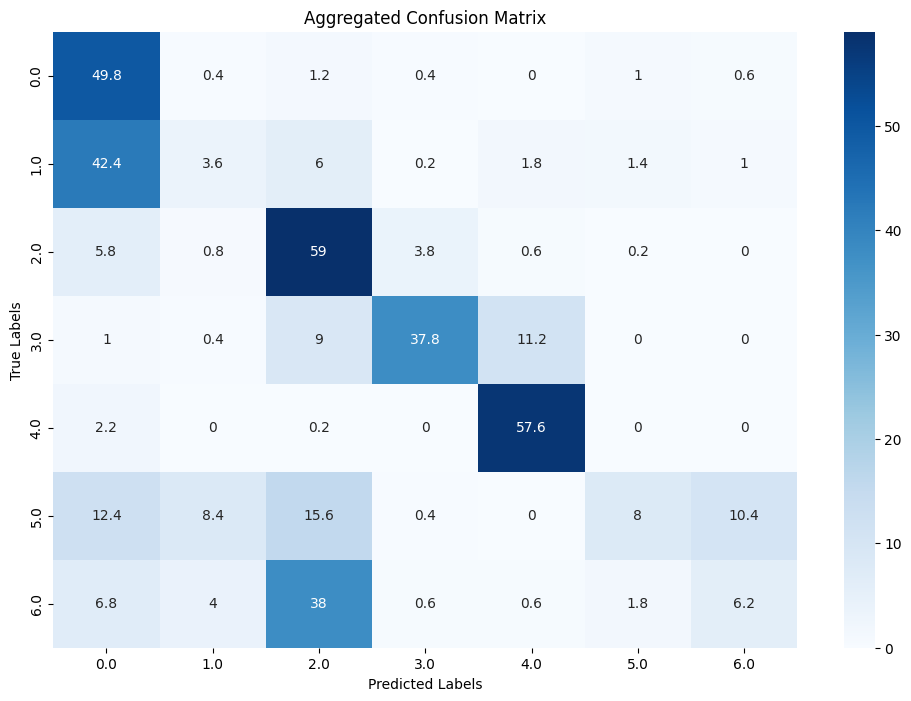

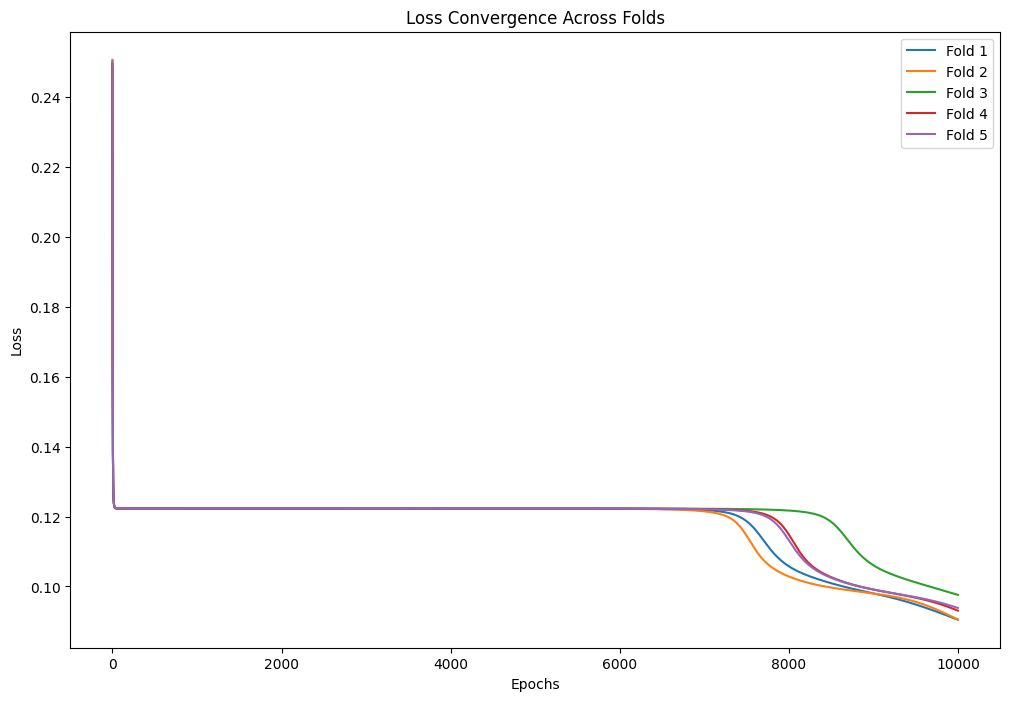

Average Convergence Speed: 0.0000156478
Average Precision: 0.5028
Average Recall: 0.5265
Average F1-Score: 0.4624


In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

# Memisahkan fitur dan target
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Convert labels to one-hot encoding
y_one_hot = pd.get_dummies(y).to_numpy()

# Convert features to numpy
X = X.to_numpy()

# Scaling features (Hanya data pelatihan yang di-fit oleh scaler)
scaler = StandardScaler()

# Initialize cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Model parameters
input_size = X.shape[1]
hidden_size1 = 10
hidden_size2 = 10
output_size = y_one_hot.shape[1]

# Placeholder for overall metrics
accuracies = []
classification_reports = []
confusion_matrices = []
convergence_speeds = []
losses_per_fold = []

# Initialize lists for precision, recall, f1-score aggregation
precision_list = []
recall_list = []
f1_score_list = []

# Cross-validation loop
for fold, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]

    # Scaling the features (fit scaler only on training data)
    X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on train
    X_test_scaled = scaler.transform(X_test)        # Only transform on test

    # Initialize the neural network
    nn = Backpropagation(
        input_size=input_size,
        hidden_size1=hidden_size1,
        hidden_size2=hidden_size2,
        output_size=output_size,
    )

    # Train the model, track loss values for convergence speed
    losses = nn.train(X_train_scaled, y_train, epochs=10000, learning_rate=0.0005, track_loss=True)
    losses_per_fold.append(losses)

    # Calculate convergence speed (rate of loss reduction)
    if len(losses) > 1:
        convergence_speed = abs((losses[-1] - losses[0]) / len(losses))
        convergence_speeds.append(convergence_speed)

    # Generate predictions
    output = nn.feedforward(X_test_scaled)
    predictions = np.argmax(output, axis=1)  # Get class with highest probability
    true_labels = np.argmax(y_test, axis=1)  # Convert one-hot to class indices

    # Calculate accuracy
    accuracy = np.mean(predictions == true_labels)
    accuracies.append(accuracy)

    # Store classification report and confusion matrix
    class_report = classification_report(true_labels, predictions, output_dict=True)
    classification_reports.append(class_report)
    confusion_matrices.append(confusion_matrix(true_labels, predictions))

    # Extract precision, recall, and f1-score for each fold
    precision_list.append(np.mean([class_report[str(i)]['precision'] for i in range(output_size)]))
    recall_list.append(np.mean([class_report[str(i)]['recall'] for i in range(output_size)]))
    f1_score_list.append(np.mean([class_report[str(i)]['f1-score'] for i in range(output_size)]))

    print(f"Fold {fold} Accuracy: {accuracy}")
    print(classification_report(true_labels, predictions))

# Average accuracy across folds
print(f"Average Accuracy: {np.mean(accuracies)}")

# Aggregate confusion matrix
average_cm = np.mean(confusion_matrices, axis=0)

# Plot aggregated confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(average_cm, annot=True, fmt='g', cmap='Blues', xticklabels=pd.get_dummies(y).columns, yticklabels=pd.get_dummies(y).columns)
plt.title("Aggregated Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot loss convergence for each fold
plt.figure(figsize=(12, 8))
for fold, losses in enumerate(losses_per_fold, start=1):
    plt.plot(losses, label=f'Fold {fold}')
plt.title("Loss Convergence Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Print convergence speed across folds
average_convergence_speed = np.mean(convergence_speeds)
print(f"Average Convergence Speed: {average_convergence_speed:.10f}")

# Calculate and print overall average precision, recall, and f1-score
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1_score = np.mean(f1_score_list)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f}")
